<a href="https://colab.research.google.com/github/stanislavprihoda/python-and-ML-courses/blob/master/FastAI/dl2/06_Cuda_CNN_hooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('//content/gdrive/My Drive/Colab Notebooks/')

In [0]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

### ConvNet

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [0]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [0]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func = func
    def forward(self,x): return self.func(x)
    
def flatten(x): return x.view(x.shape[0],-1)

In [0]:
def mnist_resize(x): return x.view(-1,1,28,28)

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1,8,5,padding=2,stride=2),nn.ReLU(), #14
        nn.Conv2d(8,16,3,padding=1,stride=2),nn.ReLU(), #7
        nn.Conv2d(16,32,3,padding=1,stride=2),nn.ReLU(),#4
        nn.Conv2d(32,32,3,padding=1,stride=2),nn.ReLU(),#2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
model = get_cnn_model(data)

In [0]:
cbfs=[Recorder,partial(AvgStatsCallback,accuracy)]

In [0]:
opt=optim.SGD(model.parameters(),lr=0.4)
learn=Learner(model,opt,loss_func,data)
run=Runner(cb_funcs=cbfs)

In [0]:
%time run.fit(1,learn)

train: [1.8144109666961985, tensor(0.3753)]
valid: [0.536404541015625, tensor(0.8279)]
CPU times: user 5.81 s, sys: 303 ms, total: 6.11 s
Wall time: 3.84 s


### CUDA

In [0]:
#more flexible way
device = torch.device('cuda',0)

In [0]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(device)
    def begin_batch(self):self.run.xb,self.run.yb=self.xb.to(device),self.yb.to(device)

In [0]:
#less flexible but quite convenient
torch.cuda.set_device(device)

In [0]:
def cuda_check():
  if not hasattr(torch._C, '_cuda_setDevice'):
      print('CUDA not available. Setting device=-1.')
      cuda_id = -1
      torch.cuda.set_device(cuda_id)
  else:
      print('Setting CUDA.')
      device = torch.device('cuda',0)
      torch.cuda.set_device(device)
cuda_check()

Setting CUDA.


In [0]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
cbfs.append(CudaCallback)

In [0]:
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(),lr=0.4)
learn = Learner(model,opt,loss_func,data)
run=Runner(cb_funcs=cbfs)

In [0]:
%time run.fit(3,learn)

train: [1.886725986126772, tensor(0.3472, device='cuda:0')]
valid: [0.792254052734375, tensor(0.7610, device='cuda:0')]
train: [0.3882678317040512, tensor(0.8771, device='cuda:0')]
valid: [0.18459130859375, tensor(0.9451, device='cuda:0')]
train: [0.17600208951025895, tensor(0.9464, device='cuda:0')]
valid: [0.17571370849609375, tensor(0.9494, device='cuda:0')]
CPU times: user 4.69 s, sys: 1.53 s, total: 6.22 s
Wall time: 8.61 s


### Model refactor

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [0]:
nfs=[8,16,32,32]

In [0]:
def get_cnn_layers(data,nfs):
  nfs = [1] + nfs
  return [
      conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
      for i in range(len(nfs)-1)
  ] + [nn.AdaptiveAvgPool2d(1),Lambda(flatten),nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data,nfs): return nn.Sequential(*get_cnn_layers(data,nfs))

In [0]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model, data, lr=0.4,cbs=cbfs)

In [0]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
run.fit(3,learn)

train: [1.902941516994201, tensor(0.3375, device='cuda:0')]
valid: [0.621032763671875, tensor(0.8119, device='cuda:0')]
train: [0.4073319189327279, tensor(0.8706, device='cuda:0')]
valid: [0.18057030029296875, tensor(0.9481, device='cuda:0')]
train: [0.17452340273513006, tensor(0.9458, device='cuda:0')]
valid: [0.1303359130859375, tensor(0.9620, device='cuda:0')]


### Hooks

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [0]:
model = SequentialModel(*get_cnn_layers(data,nfs))
learn,run = get_runner(model,data,lr=0.9,cbs=cbfs)

In [0]:
run.fit(2,learn)

train: [2.2566764280968106, tensor(0.1816, device='cuda:0')]
valid: [1.9597095703125, tensor(0.3107, device='cuda:0')]
train: [0.9893340277917606, tensor(0.6671, device='cuda:0')]
valid: [0.3051173828125, tensor(0.9030, device='cuda:0')]


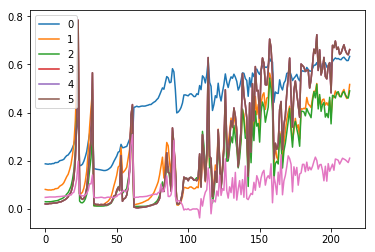

In [0]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6))

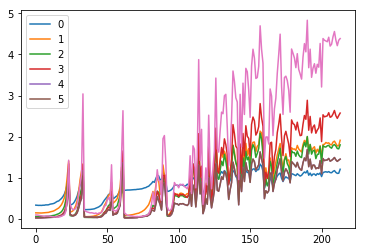

In [0]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

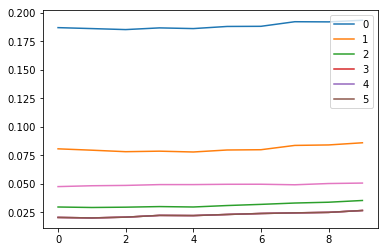

In [0]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

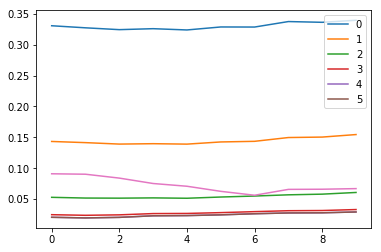

In [0]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

#### pytorch hooks

In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [0]:
def append_stats(i,model,inp,outp):
  act_means[i].append(outp.data.mean())
  act_stds[i].append(outp.data.std())

In [0]:
for i, m in enumerate(model): m. register_forward_hook(partial(append_stats,i))

In [0]:
run.fit(1,learn)

train: [2.0030366563305413, tensor(0.2871, device='cuda:0')]
valid: [1.234659375, tensor(0.6498, device='cuda:0')]


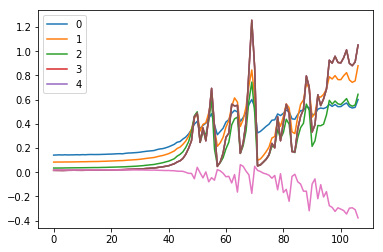

In [0]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

#### hook class

In [0]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [0]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
hooks = [Hook(l,append_stats) for l in children(model[:4])]

In [0]:
run.fit(1,learn)

train: [1.9936287476844394, tensor(0.2814, device='cuda:0')]
valid: [0.805534521484375, tensor(0.7251, device='cuda:0')]


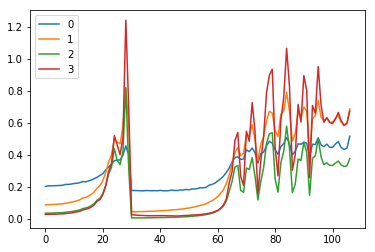

In [0]:
for h in hooks:
  plt.plot(h.stats[0])
  h.remove()
plt.legend(range(4))

#### hooks class

In [0]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [0]:
t = ListContainer(range(10));t

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [0]:
t[[1,2]],t[[False]*8+[True,False]]

([1, 2], [8])

In [0]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f5d4ec5f588>, <__main__.Hook object at 0x7f5d4ec5f358>, <__main__.Hook object at 0x7f5d4ec5f940>, <__main__.Hook object at 0x7f5d4ec5ffd0>, <__main__.Hook object at 0x7f5d4ed02208>, <__main__.Hook object at 0x7f5d4ed02358>, <__main__.Hook object at 0x7f5d4ed02780>]

In [0]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [0]:
x.mean(),x.std()

(tensor(-0.0074, device='cuda:0'), tensor(0.9922, device='cuda:0'))

In [0]:
p = model[0](x)
p.mean(),p.std()


(tensor(0.1450, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2978, device='cuda:0', grad_fn=<StdBackward0>))

In [0]:
for l in model:
  if isinstance(l,nn.Sequential):
    init.kaiming_normal_(l[0].weight)
    l[0].bias.data.zero_()

In [0]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4743, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8683, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.179697567654639, tensor(0.6036, device='cuda:0')]
valid: [0.326337890625, tensor(0.8957, device='cuda:0')]
train: [0.3735556061734858, tensor(0.8865, device='cuda:0')]
valid: [0.19014591064453126, tensor(0.9448, device='cuda:0')]


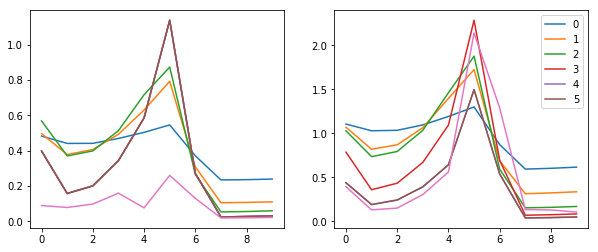

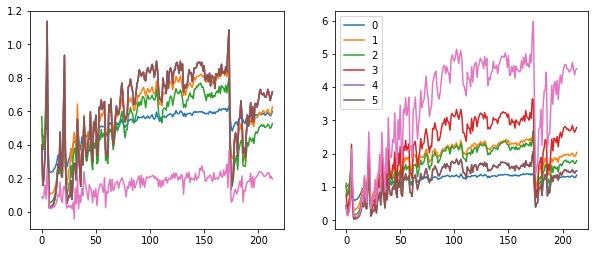

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### other statistics

In [0]:
def append_stats(hook,mod,inp,outp):
  if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
  means, stds, hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10)) #histc is not implemented on gpu

In [0]:
model = get_cnn_model(data,nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
for l in model:
  if isinstance(l,nn.Sequential):
    init.kaiming_normal_(l[0].weight)
    l[0].bias.data.zero_()

In [0]:
with Hooks(model, append_stats) as hooks: run.fit(1,learn)

train: [1.526133114529639, tensor(0.4881, device='cuda:0')]
valid: [0.46546337890625, tensor(0.8554, device='cuda:0')]


In [0]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

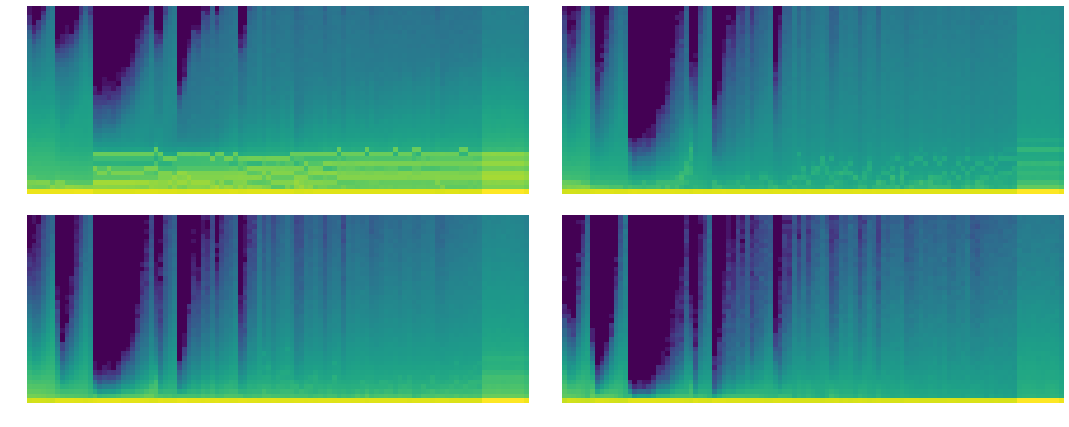

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

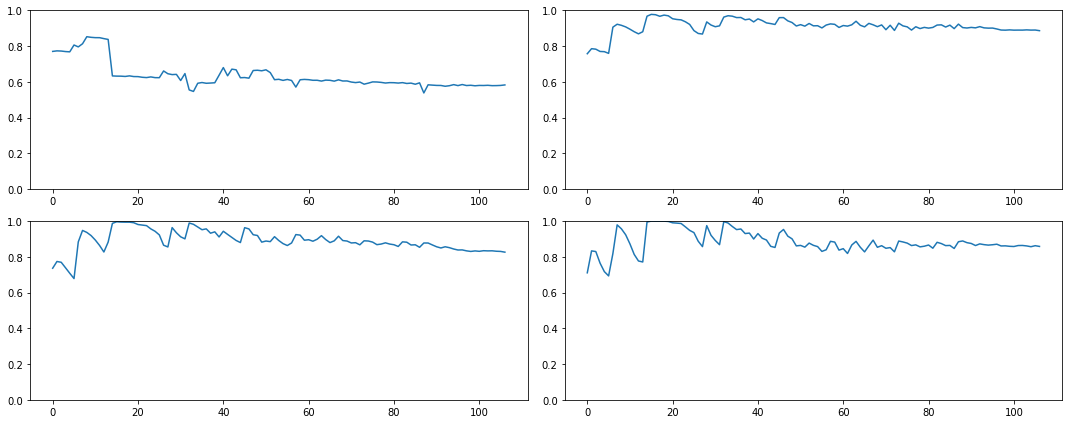

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

### generalized ReLU

In [0]:
#export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
      
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5469133829333118, tensor(0.8289, device='cuda:0')]
valid: [0.149292822265625, tensor(0.9598, device='cuda:0')]


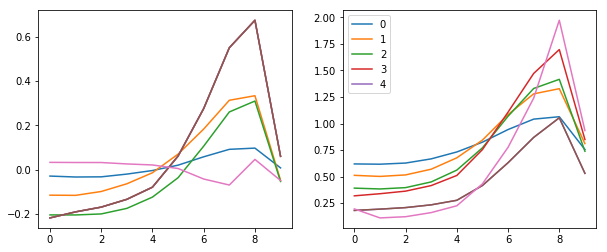

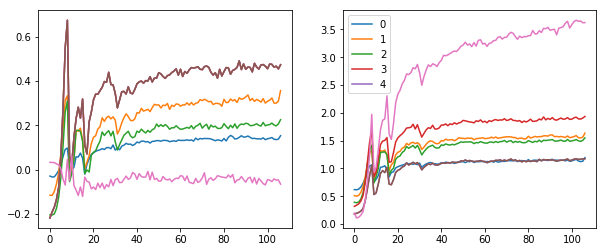

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

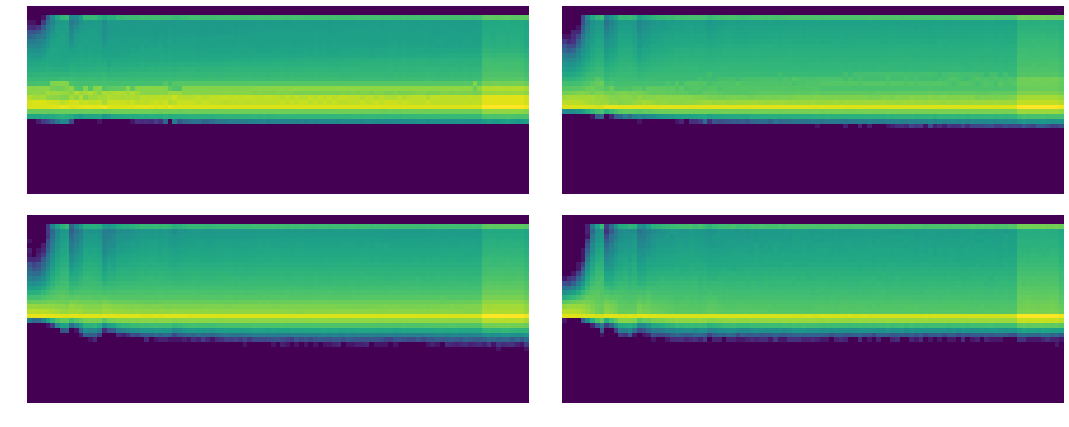

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

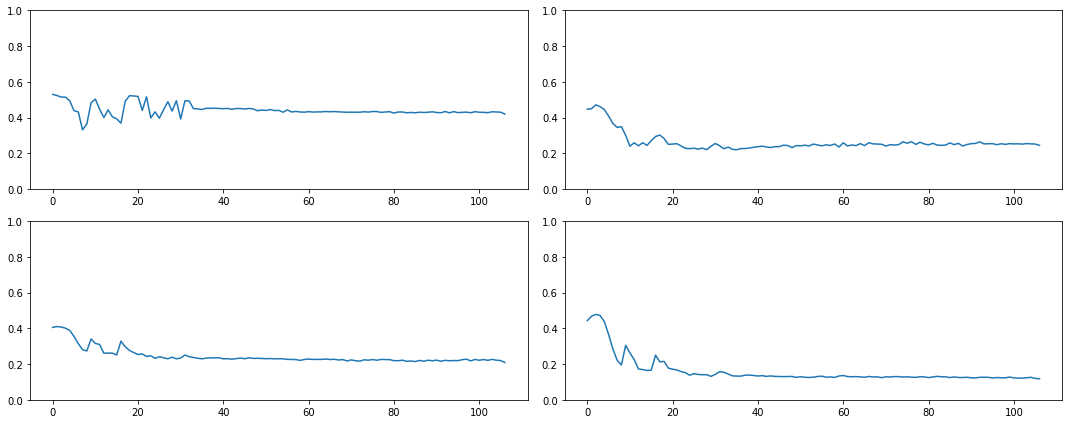

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
sched = combine_scheds([0.5,0.5],[sched_cos(0.2,1.),sched_cos(1.,0.1)])

In [0]:
learn,run = get_learn_run(nfs,data,1.,conv_layer,
                          cbs=cbfs+[partial(ParamScheduler,'lr',sched)])

In [0]:
run.fit(8,learn)

train: [1.0645903754480106, tensor(0.6592, device='cuda:0')]
valid: [0.2991622802734375, tensor(0.9105, device='cuda:0')]
train: [0.33674385621375647, tensor(0.8960, device='cuda:0')]
valid: [0.1733328125, tensor(0.9492, device='cuda:0')]
train: [0.44411936494492993, tensor(0.8663, device='cuda:0')]
valid: [0.85039580078125, tensor(0.6990, device='cuda:0')]
train: [0.27336745901206105, tensor(0.9160, device='cuda:0')]
valid: [0.1212465087890625, tensor(0.9634, device='cuda:0')]
train: [0.11636823477204312, tensor(0.9641, device='cuda:0')]
valid: [0.090290576171875, tensor(0.9718, device='cuda:0')]
train: [0.08064989699530847, tensor(0.9748, device='cuda:0')]
valid: [0.08044212036132813, tensor(0.9755, device='cuda:0')]
train: [0.061015620674054645, tensor(0.9813, device='cuda:0')]
valid: [0.0718524658203125, tensor(0.9776, device='cuda:0')]
train: [0.051006366297141795, tensor(0.9846, device='cuda:0')]
valid: [0.07098431396484375, tensor(0.9781, device='cuda:0')]


In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [0]:
run.fit(8, learn)


train: [1.0010002372191125, tensor(0.6846, device='cuda:0')]
valid: [0.307676025390625, tensor(0.9070, device='cuda:0')]
train: [0.32435649203270983, tensor(0.9018, device='cuda:0')]
valid: [0.19362562255859375, tensor(0.9409, device='cuda:0')]
train: [0.2279910844625886, tensor(0.9298, device='cuda:0')]
valid: [0.1323972412109375, tensor(0.9597, device='cuda:0')]
train: [0.23262633490808232, tensor(0.9305, device='cuda:0')]
valid: [0.11647724609375, tensor(0.9654, device='cuda:0')]
train: [0.12088695998044358, tensor(0.9634, device='cuda:0')]
valid: [0.09593908081054688, tensor(0.9717, device='cuda:0')]
train: [0.06888830047292807, tensor(0.9783, device='cuda:0')]
valid: [0.07730923461914062, tensor(0.9776, device='cuda:0')]
train: [0.052984208175816484, tensor(0.9837, device='cuda:0')]
valid: [0.06936776123046876, tensor(0.9803, device='cuda:0')]
train: [0.0441416415971579, tensor(0.9863, device='cuda:0')]
valid: [0.06932864990234375, tensor(0.9813, device='cuda:0')]


## Export

In [0]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [0]:
nb_auto_export()